# **Anomaly Detection in the Bitcoin Transaction Network**

---

An anomaly detection analysis performed on the Bitcoin network using the DeltaCon algorithm. The goal is to find if it is possible to detect significant price drops through graph analysis.

Link to the paper for DeltaCon: https://epubs.siam.org/doi/epdf/10.1137/1.9781611972832.18

Link to the dataset: ***btc_tx2.csv*** in https://drive.google.com/drive/folders/1MEyMfmdencAh8AJRxFTEZWRV3l-2n1IF?usp=sharing

**TEAM 1:**

**Sravya Yepuri - PES1UG19CS502  Section: H**

**Sahana B Manjunath - PES1UG19CS411  Section: G**

**Faraaz Khan - PES1UG19CS153  Section: C**

**Raghav Pandit - PES1UG19CS364 Section: F**

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import concatenate, square, array, trace, amax
from math import sqrt
from tqdm.notebook import tqdm
from datetime import datetime
from datetime import timedelta
from scipy.sparse import identity, diags
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/'
#Create a folder DataBTC under MyDrive to store all the csv's generated in this code. 
#btc_tx2.csv is the dataset that we use for our project and needs to be uploaded under DataBTC.
filepath_full_data = path + 'DataBTC/btc_tx2.csv'
savepath = path + 'DataBTC/'

## **Helper Functions**

In [ ]:
#Takes as input the raw data and ouput a correspondance table between wallet addresse to indices
def wal_conversion_table(filepath, savepath):
    
    # load the file in a pandas dataframe
    df = pd.read_csv(filepath)
    
    # list every wallet addresses in lists
    source_addresses = []
    target_addresses = []
    
    # loop over the dataframe
    for row in tqdm(range(len(df))):
        source_addresses.append(df.from_address[row])
        target_addresses.append(df.to_address[row])
        
    
    # concatenate lists
    wallets = source_addresses + target_addresses
    
    # remove duplicate from the list
    wallets = np.unique(wallets).tolist()
    
    # print the number of single source / target wallets / unique wallet
    print("Number of sources: {:,}".format(len(np.unique(source_addresses))))
    print("Number of targets: {:,}".format(len(np.unique(target_addresses))))
    print("Number of wallets: {:,}".format(len(wallets)))
    
    # get the indices
    indices = np.arange(0, len(wallets)).tolist()
    
    
    # create a conversion dataframe
    conversion_df = pd.DataFrame(list(zip(wallets, indices)),
               columns =['wallet_address', 'index'])
    
    
    # save the conversion dataframe
    conversion_df.to_csv(path_or_buf= savepath + "conversion_df.csv", sep=',')
    
    return df, conversion_df

def preprocessing(token_transactions_df, conversion_df):
    
    # create a dictionary that will store the wallet_address and their corresponding index
    dictionary = conversion_df.set_index('wallet_address').to_dict()
    
    # create new from/to_address columns replace token addresses by their indices
    token_transactions_df['from_address_idx'] = token_transactions_df['from_address'].apply(lambda x: dictionary['index'][x])
    token_transactions_df['to_address_idx'] = token_transactions_df['to_address'].apply(lambda x: dictionary['index'][x])
    
    # create new value and gas columns in ETH
    # 1 ETH = 1,000,000,000,000,000,000 wei (10^18)
    conv_rate =  1.0e+18
    token_transactions_df['value_eth'] = token_transactions_df['amount'] / conv_rate
    #token_transactions_df['gas_price_eth'] = token_transactions_df['gas_price'] / conv_rate
    #token_transactions_df['receipt_gas_used_eth'] = token_transactions_df['receipt_gas_used'] / conv_rate
    
    
    # Convert timestamps to datetime format
    token_transactions_df['block_timestamp_true'] =  pd.to_datetime(token_transactions_df['datetime'])
    
    
    # Drop useless columns
    token_transactions_df.drop(columns=['amount', 
                                        'datetime',
                                        'from_address', 
                                        'to_address'],
                               axis=1, inplace=True)
    
    
    
    
    
    return token_transactions_df

In [ ]:
# Function that returns the list of nodes in both graphs
def add_missing_nodes(G1, G2):
  union = G1.nodes() | G2.nodes()
  return list(union)

# Function that lists every nodes and weight to create the weighted directed graph
def tuples_graph(df):
  new_df = df[['from_address_idx', 'to_address_idx', 'value_eth']]
  tuples_graph = [tuple(x) for x in new_df.to_numpy()]
  return tuples_graph


# Function that creates two directed graphs having the same node set
def create_new_graph(G1, G2, df1, df2):
  unions = add_missing_nodes(G1, G2)
  tuples_graphs1 = tuples_graph(df1)
  tuples_graphs2 = tuples_graph(df2)
  new_G1 = nx.DiGraph()
  new_G2 = nx.DiGraph()
  new_G1.add_nodes_from(unions)
  new_G1.add_weighted_edges_from(tuples_graphs1)
  new_G2.add_nodes_from(unions)
  new_G2.add_weighted_edges_from(tuples_graphs2)  
  return new_G1, new_G2

# Function plotting lollipop chart
def lollipop_chart(similarities_df, k=2):
    '''
    
    Parameters
    ----------
    similarities_df : Dataframe
        Similarity scores for each combination of consecutive subgraph.
    k : Integer, optional
        Variable controlling the Upper Control Limit. The default is 2.
    Returns
    -------
    Lollipop chart
    '''
    data = similarities_df.similarity 
    x= similarities_df.time
    
    line = [np.mean(data)]*len(x)
    LCL = [max(np.median(data) - k*np.std(data),0)]*len(x)
    UCL = [np.median(data) + k*np.std(data)]*len(x)
    ref_line = line-data
    
    # lollipop chart 
    plt.figure(figsize=(20,15))
    plt.stem(x, data, bottom = np.mean(data), use_line_collection= True)
    plt.plot(x, line)
    plt.plot(x, LCL, "r--")
    plt.plot(x, UCL, "r--")
    plt.xticks(rotation=90)
    plt.show()
    
    
# Funtion that returns the list of similarity scores
def sim_computation(list_timelines):
    
    similarity = []
    
    for i in tqdm(range(len(list_timelines)-2)):
    
        # Get the dataframes
        df1 = pd.read_csv(savepath+ file_names[i], sep = ',',
                          dtype={"from_address_idx": str, 
                                 "to_address_idx": str, 
                                 "value_eth":float
                                 }
                          )
        
        df2 = pd.read_csv(savepath+ file_names[i+1], sep = ',',
                      dtype={"from_address_idx": str, 
                             "to_address_idx": str, 
                             "value_eth":float
                             }
                      )
        if df1.shape[0] < 2 or df2.shape[0] < 2:
          continue    
        # Create graphs
        G1 = nx.from_pandas_edgelist(df1, 'from_address_idx', 'to_address_idx')
        G2 = nx.from_pandas_edgelist(df2, 'from_address_idx', 'to_address_idx')
        
        # Get the weighted graphs
        n_G1, n_G2 = create_new_graph(G1, G2, df1, df2)
        
        # Compute the similarity with Deltacon
        sim = DeltaCon(n_G1, n_G2)
        
        # append the similarity list
        similarity.append(sim)
    
    return(similarity)

In [ ]:
# Function computing the similarity scores between two graphs
def DeltaCon(G1, G2):
    '''
    Parameters
    ----------
    G1 : TYPE: (Weighted) Directed Graph
    G2 : TYPE: (Weighted) Directed Graph
    Both Graphs should have the same node set.
    Returns
    -------
    sim : TYPE: float
        Similarity score.
    '''
    
    # Get the Adjacency matrix
    A1, A2 = GenAdjacencyMatrix(G1, G2)
  
    # Get the silmilarity score
    sim=Similarity(A1, A2)
    
    return sim
    

# Function that computing the adjacency matrix of two graphs
def GenAdjacencyMatrix(G1, G2):
    '''
    
    Parameters
    ----------
    G1 : (Weighted) Directed Graph
    G2 : (Weighted) Directed Graph
    Returns
    -------
    A1 : SciPy sparse matrix
        Adjacency matrix representation of G1.
    A2 : SciPy sparse matrix
        Adjacency matrix representation of G2.
	Use Fast Belief Propagation
	CITATION: Danai Koutra, Tai-You Ke, U. Kang, Duen Horng Chau, Hsing-Kuo
	Kenneth Pao, Christos Faloutsos
	Unifying Guilt-by-Association Approaches
	return [I+a*D-c*A]^-1
	'''


    # Get the nodelist to order the adjacency matrix
    nodelist = list(G1.nodes())
    
    # Get the adjacency matrices
    A1 = nx.adjacency_matrix(G1, nodelist=nodelist)
    A2 = nx.adjacency_matrix(G2, nodelist=nodelist)

    return A1, A2


# Function returning the inverse matrix of the adjacency matrix
def InverseMatrix(A):
    '''
    Parameters
    ----------
    A : SciPy sparse matrix
        Adjacency matrix representation.
    Returns
    -------
    TYPE
        DESCRIPTION.
	Use Fast Belief Propagation
	CITATION: Danai Koutra, Tai-You Ke, U. Kang, Duen Horng Chau, Hsing-Kuo
	Kenneth Pao, Christos Faloutsos
	Unifying Guilt-by-Association Approaches
	return [I+a*D-c*A]^-1
	'''
    
    I=identity(A.shape[0])		#identity matrix
    D=diags(sum(A).toarray(), [0])	#diagonal degree matrix

    c1=trace(D.toarray())+2
    c2=trace(square(D).toarray())-1
    h_h=sqrt((-c1+sqrt(c1*c1+4*c2))/(8*c2))
    if(h_h == 0.5):
      h_h = 0.4999999
    #print(h_h)
    #x = float(4*h_h*h_h)
    #a = x / (1 - x)
    a=4*h_h*h_h/(1-4*h_h*h_h)
    c=2*h_h // (1-4*h_h*h_h)
	
    '''
	compute the inverse of matrix [I+a*D-c*A]
	use the method propose in Unifying Guilt-by-Association equation 5
	'''	
	
    M=c*A-a*D
    S=I
    mat=M
    power=1
    while amax(M.toarray())>10**(-9) and power<7:
        S=S+mat
        mat=mat*M
        power+=1

    return S
  




# Function computing the similarity score based on the DeltaCon0 algorithm
def Similarity(A1, A2):
    '''
    
    Parameters
    ----------
    A1 : SciPy sparse matrix
        Adjacency matrix representation of G1.
    A2 : SciPy sparse matrix
        Adjacency matrix representation of G2.
    Returns
    -------
    Similarity : Float
    
    Use deltacon0 to compute similarity
    CITATION: Danai Koutra, Joshua T. Vogelstein, Christos Faloutsos
    DELTACON: A Principled Massive-Graph Similarity Function
    '''
    S1=InverseMatrix(A1)
    S2=InverseMatrix(A2)
    S1_temp = np.sqrt(S1)
    S2_temp = np.sqrt(S2)
    
    result_temp  = np.power(S1_temp - S2_temp, 2) 
    
    d = np.sum(result_temp, axis=1)
    d = np.sum(d, axis=0)
    
    d=np.sqrt(d)
    sim=1/(1+d)
    return sim.item()

## **Preprocessing**

### **Create a conversion table that maps wallets to a single index**

In [ ]:
full_df, conversion_df = wal_conversion_table(filepath_full_data, savepath)

  0%|          | 0/844836 [00:00<?, ?it/s]

Number of sources: 497,545
Number of targets: 479,282
Number of wallets: 515,358


In [ ]:
full_df.head()

,from_address,to_address,datetime,amount
0,99fc836cc49d4d44d86050b14ce6bc62710e7ba6f5cc72...,59d30902c77c2c4bbf792900e662791dd77700c0d444f8...,02-01-2011 03:30,0.01
1,99fc836cc49d4d44d86050b14ce6bc62710e7ba6f5cc72...,6e82f571552e115869019c1c55c04103fc920e1c608c7e...,02-01-2011 03:30,1.00
2,6510fffcd65373d850c9494a8327f9602edd4b878aba67...,264e456a53b5acdb5415f5d8a43294cc3504a2e62fe9d9...,02-01-2011 03:30,48.34
3,6510fffcd65373d850c9494a8327f9602edd4b878aba67...,177fcc84bd5ebcc7b5fd5001013b3998e9a6edd57f93b4...,02-01-2011 03:30,0.66
4,09fe4e59ee2e8b248e084347a7b3ff4932fe78e40a22ff...,0d37b4d8302d157652d33de377988806a9a3e3f196f198...,02-01-2011 03:30,47.76


### **Preprocess Dataframes**

In [ ]:
# Load conversion table
conversion_df = pd.read_csv(savepath + 'conversion_df.csv')

# Load csv files
Jan19_31 = pd.read_csv(savepath + 'btc_tx2.csv')

In [ ]:
conversion_df.head()

,Unnamed: 0,wallet_address,index
0,0,000008121f0f9213aa64bc1b40adad82c0c73c681bda78...,0
1,1,000010ab9378a649fe2d57387afeb4b066a6fa396cefcc...,1
2,2,000016439fa06fee27f5199c360f920905adf5997cb3af...,2
3,3,00003e57a3dbf850079b59b172ee9ccff254933b336c11...,3
4,4,00007753396e6a9b9f25d9c20605cf1a0e32fe7c9f4ba2...,4


In [ ]:
Jan19_31.head()

,from_address,to_address,datetime,amount
0,99fc836cc49d4d44d86050b14ce6bc62710e7ba6f5cc72...,59d30902c77c2c4bbf792900e662791dd77700c0d444f8...,02-01-2011 03:30,0.01
1,99fc836cc49d4d44d86050b14ce6bc62710e7ba6f5cc72...,6e82f571552e115869019c1c55c04103fc920e1c608c7e...,02-01-2011 03:30,1.00
2,6510fffcd65373d850c9494a8327f9602edd4b878aba67...,264e456a53b5acdb5415f5d8a43294cc3504a2e62fe9d9...,02-01-2011 03:30,48.34
3,6510fffcd65373d850c9494a8327f9602edd4b878aba67...,177fcc84bd5ebcc7b5fd5001013b3998e9a6edd57f93b4...,02-01-2011 03:30,0.66
4,09fe4e59ee2e8b248e084347a7b3ff4932fe78e40a22ff...,0d37b4d8302d157652d33de377988806a9a3e3f196f198...,02-01-2011 03:30,47.76


In [ ]:
Jan19_31_clean = preprocessing(Jan19_31, conversion_df)

In [ ]:
Jan19_31_clean

,from_address_idx,to_address_idx,value_eth,block_timestamp_true
0,309756,180617,1.000000e-20,2011-02-01 03:30:00
1,309756,222108,1.000000e-18,2011-02-01 03:30:00
2,203065,77367,4.834000e-17,2011-02-01 03:30:00
3,203065,47333,6.600000e-19,2011-02-01 03:30:00
4,20213,26654,4.776000e-17,2011-02-01 03:30:00
...,...,...,...,...
844831,487326,98129,7.200000e-19,2011-06-14 05:59:00
844832,279120,300983,1.332666e-16,2011-06-14 05:59:00
844833,160007,127575,1.272916e-16,2011-06-14 05:59:00
844834,165747,375909,1.036818e-16,2011-06-14 05:59:00


## **Create dataframe for each timeframe**

**Create lists with storing dates as strings and datatimes**

In [ ]:
x = datetime.strptime('2011-02-01 02:30:00', '%Y-%m-%d %H:%M:%S')

list_timelines = []
list_datetime = []

n = 96

for i in tqdm(range(0, n)):
    dt = x + timedelta(hours=i)
    list_datetime.append(dt)
    list_timelines.append(dt.strftime('%Y-%m-%d %H:%M:%S'))
#list_timelines = list_timelines[:-1]
list_timelines

  0%|          | 0/96 [00:00<?, ?it/s]

['2011-02-01 02:30:00',
 '2011-02-01 03:30:00',
 '2011-02-01 04:30:00',
 '2011-02-01 05:30:00',
 '2011-02-01 06:30:00',
 '2011-02-01 07:30:00',
 '2011-02-01 08:30:00',
 '2011-02-01 09:30:00',
 '2011-02-01 10:30:00',
 '2011-02-01 11:30:00',
 '2011-02-01 12:30:00',
 '2011-02-01 13:30:00',
 '2011-02-01 14:30:00',
 '2011-02-01 15:30:00',
 '2011-02-01 16:30:00',
 '2011-02-01 17:30:00',
 '2011-02-01 18:30:00',
 '2011-02-01 19:30:00',
 '2011-02-01 20:30:00',
 '2011-02-01 21:30:00',
 '2011-02-01 22:30:00',
 '2011-02-01 23:30:00',
 '2011-02-02 00:30:00',
 '2011-02-02 01:30:00',
 '2011-02-02 02:30:00',
 '2011-02-02 03:30:00',
 '2011-02-02 04:30:00',
 '2011-02-02 05:30:00',
 '2011-02-02 06:30:00',
 '2011-02-02 07:30:00',
 '2011-02-02 08:30:00',
 '2011-02-02 09:30:00',
 '2011-02-02 10:30:00',
 '2011-02-02 11:30:00',
 '2011-02-02 12:30:00',
 '2011-02-02 13:30:00',
 '2011-02-02 14:30:00',
 '2011-02-02 15:30:00',
 '2011-02-02 16:30:00',
 '2011-02-02 17:30:00',
 '2011-02-02 18:30:00',
 '2011-02-02 19:

In [ ]:
# Get the file_names
file_names = []

for i in tqdm(range(0, n)):
    
    dt = list_datetime[i]
    file_names.append('2011_0' + str(dt.month) + '_' + str(dt.day) + '_' + str(dt.hour) + '.csv')
file_names = file_names[:-1]
file_names

  0%|          | 0/96 [00:00<?, ?it/s]

['2011_02_1_2.csv',
 '2011_02_1_3.csv',
 '2011_02_1_4.csv',
 '2011_02_1_5.csv',
 '2011_02_1_6.csv',
 '2011_02_1_7.csv',
 '2011_02_1_8.csv',
 '2011_02_1_9.csv',
 '2011_02_1_10.csv',
 '2011_02_1_11.csv',
 '2011_02_1_12.csv',
 '2011_02_1_13.csv',
 '2011_02_1_14.csv',
 '2011_02_1_15.csv',
 '2011_02_1_16.csv',
 '2011_02_1_17.csv',
 '2011_02_1_18.csv',
 '2011_02_1_19.csv',
 '2011_02_1_20.csv',
 '2011_02_1_21.csv',
 '2011_02_1_22.csv',
 '2011_02_1_23.csv',
 '2011_02_2_0.csv',
 '2011_02_2_1.csv',
 '2011_02_2_2.csv',
 '2011_02_2_3.csv',
 '2011_02_2_4.csv',
 '2011_02_2_5.csv',
 '2011_02_2_6.csv',
 '2011_02_2_7.csv',
 '2011_02_2_8.csv',
 '2011_02_2_9.csv',
 '2011_02_2_10.csv',
 '2011_02_2_11.csv',
 '2011_02_2_12.csv',
 '2011_02_2_13.csv',
 '2011_02_2_14.csv',
 '2011_02_2_15.csv',
 '2011_02_2_16.csv',
 '2011_02_2_17.csv',
 '2011_02_2_18.csv',
 '2011_02_2_19.csv',
 '2011_02_2_20.csv',
 '2011_02_2_21.csv',
 '2011_02_2_22.csv',
 '2011_02_2_23.csv',
 '2011_02_3_0.csv',
 '2011_02_3_1.csv',
 '2011_02_3_

**Generate CSV**

In [ ]:
for i in tqdm(range(len(list_timelines)-1)):
    
    # Generate the dataframe
    df = Jan19_31_clean[(Jan19_31_clean['block_timestamp_true'] >= list_timelines[i]) & (Jan19_31_clean['block_timestamp_true'] < list_timelines[i+1])]
    df
    # Get the datetimes
    dt = list_datetime[i]
    
    # Generate the names
    name_csv = '2011_0' + str(dt.month) + '_' + str(dt.day) + '_' + str(dt.hour) + '.csv'
    
    # save the csv to the save path
    df.to_csv(savepath+ name_csv, sep = ',', index = False)

  0%|          | 0/95 [00:00<?, ?it/s]

## **Anomaly Detection**

**Compute Similarities**

In [ ]:
similarity = sim_computation(list_timelines)

  0%|          | 0/94 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:136: Runtim

In [ ]:
# create the dataframe
similarities_df = pd.DataFrame(list(zip(list_timelines[:-2], similarity)), 
                               columns =['time', 'similarity'])

column_means = similarities_df['similarity'].median()

similarities_df = similarities_df.fillna(column_means)
similarities_df['similarity']= 1 -  similarities_df['similarity']
similarities_df

,time,similarity
0,2011-02-01 02:30:00,0.000070
1,2011-02-01 03:30:00,0.000178
2,2011-02-01 04:30:00,0.000198
3,2011-02-01 05:30:00,0.000093
4,2011-02-01 06:30:00,0.000132
...,...,...
89,2011-02-04 19:30:00,0.000132
90,2011-02-04 20:30:00,0.000132
91,2011-02-04 21:30:00,0.000069
92,2011-02-04 22:30:00,0.000135


In [ ]:
# Save the dataframe
with open(savepath + 'similarities_df.pkl', 'wb') as f:
  pickle.dump(similarities_df, f)

In [ ]:
# Load the similarity dataframe
similarities_df = pickle.load(open(savepath +'similarities_df.pkl', 
                                   'rb'))

## **Plot the Observations**

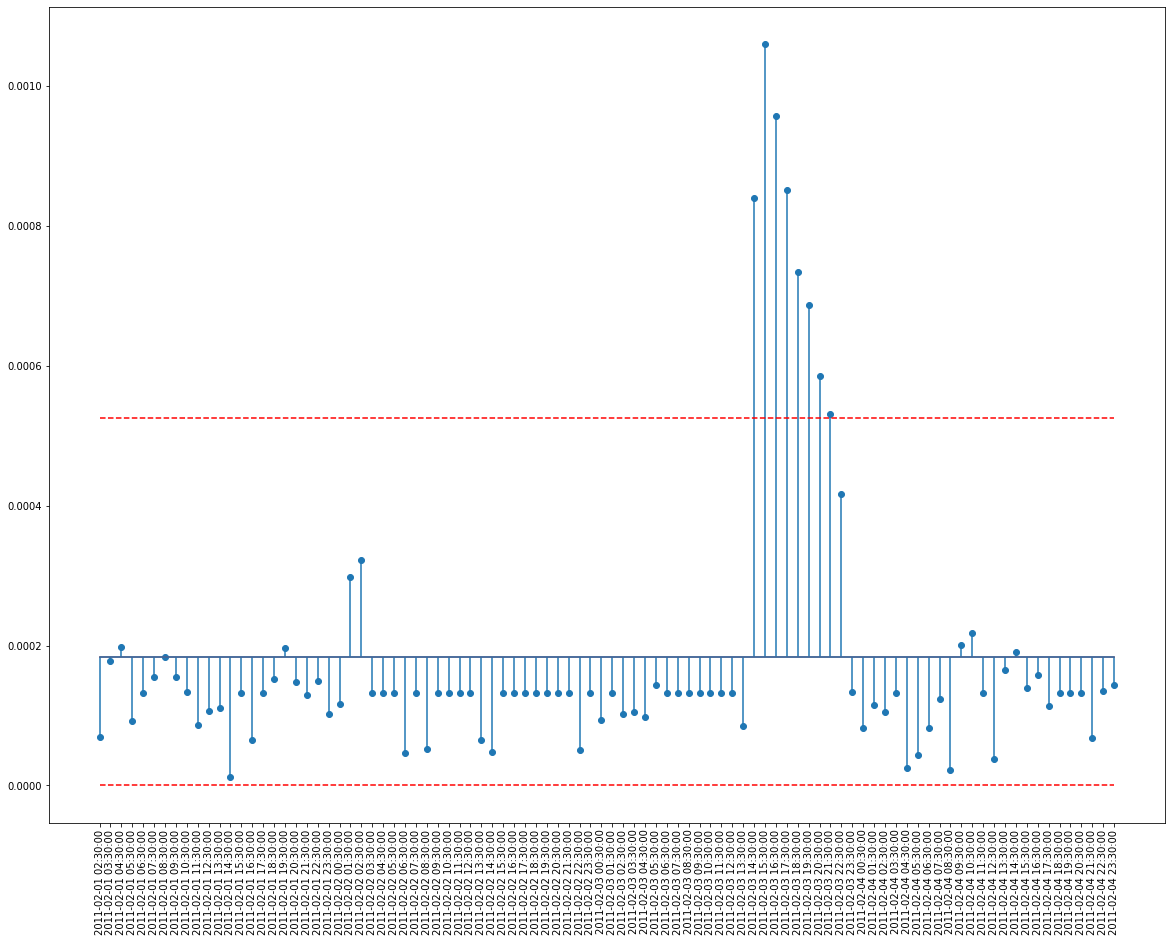

In [ ]:
lollipop_chart(similarities_df, k=2)

In [ ]:
similarities_df.similarity.describe()

count    94.000000
mean      0.000183
std       0.000198
min       0.000013
25%       0.000106
50%       0.000132
75%       0.000149
max       0.001060
Name: similarity, dtype: float64

**As shown in cell above, the similarity scores were rather low from one hour to another which is not surprising as Bitcoin owners do not transact continuously during normal times. Therefore, we decided to put a threshold for values that are above the normal range of observed values. This threshold (Upper Control Limit) corresponds to median, similarity scores above this value refers to anomalies as this might denote a possible frenzy in the market.**